Redes Generativas Adversarias 2


Jonnatan Arias Garcia

jonnatan.arias@utp.edu.co

jariasg@uniquindio.edu.co

# Deep Convolutional Generative Adversarial Networks (DCGANs)


Trabajas para una empresa de videojuegos de anime online; A la empresa le gustaría crear un avatar de anime único para un juego para cada jugador. Como hay millones de jugadores, debes usar DCGAN para crear cada personaje.


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/face_cartton.png" width="700" alt="Skills Network Logo">


## Setup


In [2]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
#!mamba install -qy numpy==1.22.3 matplotlib==3.5.1 tensorflow==2.9.0
!pip install skillsnetwork==0.20.6

# Note: If your environment doesn't support "!mamba install", use "!pip install --user"

# RESTART YOUR KERNEL AFTERWARD AS WELL

### Importing Required Libraries



In [3]:
import warnings
warnings.simplefilter('ignore')

import keras

import numpy as np
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2DTranspose,BatchNormalization,ReLU,Conv2D,LeakyReLU


from IPython import display
import skillsnetwork
print(f"skillsnetwork version: {skillsnetwork.__version__}")

import matplotlib.pyplot as plt

%matplotlib inline


import os
from os import listdir
from pathlib import Path
import imghdr

import time
from tqdm.auto import tqdm


tensorflow version: 2.15.0
skillsnetwork version: 0.20.6


### Defining Helper Functions

Esta función trazará cinco imágenes de una matriz.


In [4]:
def plot_array(X,title=""):

    plt.rcParams['figure.figsize'] = (20,20)

    for i,x in enumerate(X[0:5]):
        x=x.numpy()
        max_=x.max()
        min_=x.min()
        xnew=np.uint(255*(x-min_)/(max_-min_))
        plt.subplot(1,5,i+1)
        plt.imshow(xnew)
        plt.axis("off")

    plt.show()

## Introduction


Anteriormente, aprendimos sobre la mecánica de funcionamiento de las redes generativas adversarias (GAN) y sus diversas aplicaciones, como la generación de imágenes. Sin embargo, también se sabe que las GAN son inestables para entrenar y, a menudo, las imágenes generadas son ruidosas e incomprensibles.

La aplicación de redes neuronales convolucionales a GANS ha dado lugar a mejores resultados. Se denominan redes adversarias generativas convolucionales profundas (DCGAN). En este laboratorio, construiremos y entrenaremos DCGAN utilizando varios enfoques introducidos en el <a href="https://arxiv.org/pdf/1511.06434.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork- Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01">Documento DCGANs</a>.


Los enfoques propuestos se resumen aquí:


- Reemplace cualquier capa de agrupación con **strided convolutions (discriminator)** y **fractional-strided
convolutions (generator)**.
- Utilice **batchnorm** tanto en el generador como en el discriminador.
- **Elimine capas ocultas completamente conectadas** para arquitecturas más profundas.
- Utilice la activación **ReLU** en el generador para todas las capas excepto para la salida, que utiliza **Tanh**.
- Utilice la activación **LeakyReLU** en el discriminador para todas las capas excepto para la salida, que utiliza **Sigmoide**.
- Utilice **optimizador Adam**.

Estos enfoques darán como resultado un entrenamiento más estable de modelos generativos más profundos.


## Dataset

Trabajaremos principalmente con el conjunto de datos Anime Face de [Kaggle](https://www.kaggle.com/datasets/splcher/animefacedataset?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkill sNetworkML311Coursera747-2022- 01-01). El conjunto de datos original tiene 63.632 caras de anime de "alta calidad", pero para que los modelos se entrenen más rápido en este laboratorio, tomamos muestras aleatorias de 20.000 imágenes y preparamos un conjunto de datos llamado "cartoon_20000".

Descarguemos el conjunto de datos más pequeño usando la función "preparar" de la biblioteca Skills Network:

In [5]:
dataset_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/cartoon_20000.zip"
await skillsnetwork.prepare(dataset_url, overwrite=True)

  0%|          | 0/20001 [00:00<?, ?it/s]

Saved to '.'


Las imágenes de Anime Face o Cartoon se almacenan en la carpeta `cartoon_2000` en su directorio de trabajo actual. Como paso de preprocesamiento, hemos eliminado los archivos que no tienen formatos de imagen adecuados (según las extensiones de archivo) y las imágenes duplicadas.


## Creando el Data Generator


Primero, declaramos algunas propiedades de nuestras imágenes, incluida la altura de la imagen, el ancho de la imagen y el tamaño del lote.


In [6]:
img_height, img_width, batch_size=64,64,128

A continuación, creamos un objeto Keras <code>image_dataset_from_directory</code> con un directorio de imágenes específico y los parámetros se definen como se indica arriba. Este proceso puede tardar algún tiempo:


In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory='cartoon_20000', # change directory to 'cartoon_data' if you use the full dataset
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       label_mode=None)


Found 20000 files belonging to 1 classes.


El `train_ds` que definimos es un `tf.data.Dataset` que produce lotes de imágenes con `image_size = (64, 64)` del directorio o subdirectorios especificados (si los hay).


Aplicamos la función Lambda en `train_ds` para normalizar los valores de píxeles de todas las imágenes de entrada desde $[0, 255]$ a $[-1, 1]$:


In [8]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x: normalization_layer(x))

Tomemos un lote de imágenes para mostrar:


In [9]:
images=train_ds.take(1)

Convierta la dimensión del lote a los índices de una lista:


In [10]:
X=[x for x in images]

Luego podemos trazar las primeras cinco imágenes del lote usando la función ```plot_array```:


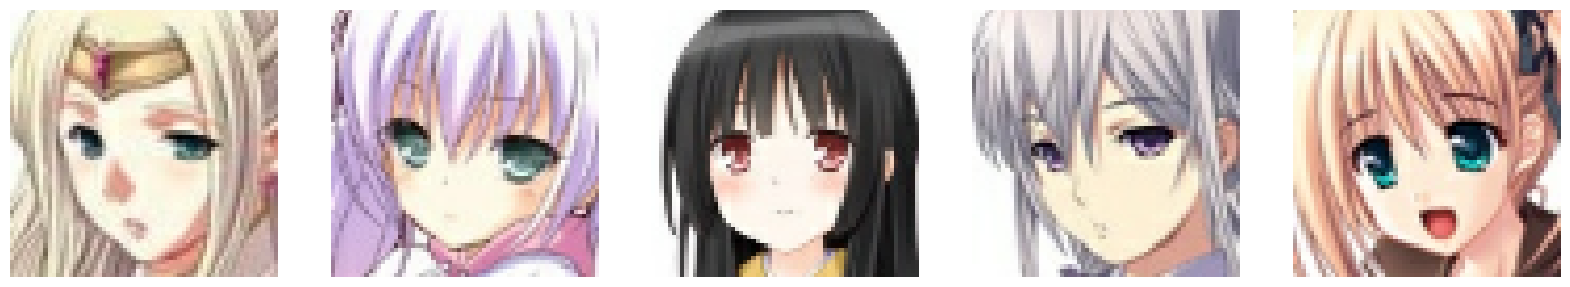

In [11]:
plot_array(X[0])

##  Generador & Discriminador


### Construyendo el Generador


El Generador se compone de varias capas de convolución transpuesta, lo opuesto a las operaciones de convolución.

- Cada capa Conv2DTranspose (excepto la capa final) va seguida de una capa de Normalización por lotes y una **activación Relu**; Para obtener más detalles sobre la implementación, consulte <a href="https://arxiv.org/pdf/1511.06434.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNet trabajoML311Coursera747-2022-01-01" >[1]</a>.
- La capa de convolución de transposición final tiene tres canales de salida, ya que la salida debe ser una imagen en color. Usamos la **activación Tanh** en la capa final.

Vea la ilustración de la arquitectura de <a href="https://arxiv.org/pdf/1511.06434.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNet trabajoML311Coursera747-2022-01-01" >[1]</a> a continuación.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/generator.png" alt="generator imagen" ancho="80%"></center>

Construimos la red Generador utilizando los valores de los parámetros de <a href="https://learnopencv.com/deep-convolutional-gan-in-pytorch-and-tensorflow/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA -SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01" >[2]<a>.

In [12]:
def make_generator():

    model=Sequential()

    # input is latent vector of 100 dimensions
    model.add(Input(shape=(1, 1, 100), name='input_layer'))

    # Block 1 dimensionality of the output space  64 * 8
    model.add(Conv2DTranspose(64 * 8, kernel_size=4, strides= 4, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(ReLU(name='relu_1'))

    # Block 2: input is 4 x 4 x (64 * 8)
    model.add(Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(ReLU(name='relu_2'))

    # Block 3: input is 8 x 8 x (64 * 4)
    model.add(Conv2DTranspose(64 * 2, kernel_size=4,strides=  2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3'))
    model.add(ReLU(name='relu_3'))


    # Block 4: input is 16 x 16 x (64 * 2)
    model.add(Conv2DTranspose(64 * 1, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4'))
    model.add(ReLU(name='relu_4'))

    model.add(Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,
                              activation='tanh', name='conv_transpose_5'))

    return model

Al imprimir el resumen de la arquitectura del Generador, podemos ver que las convoluciones transpuestas **aumentan la muestra** un vector de entrada de 100 niveles de intensidad a una imagen de alta dimensión de tamaño 64 x 64 x 3.


In [13]:
gen = make_generator()
gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_transpose_1 (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 bn_1 (BatchNormalization)   (None, 4, 4, 512)         2048      
                                                                 
 relu_1 (ReLU)               (None, 4, 4, 512)         0         
                                                                 
 conv_transpose_2 (Conv2DTr  (None, 8, 8, 256)         2097152   
 anspose)                                                        
                                                                 
 bn_2 (BatchNormalization)   (None, 8, 8, 256)         1024      
                                                                 
 relu_2 (ReLU)               (None, 8, 8, 256)         0

### Construyendo el Discriminador


El Discriminador tiene cinco capas de convolución.

- Todas las capas Conv2D, excepto la primera y la última, tienen normalización por lotes, ya que la aplicación directa de la norma por lotes a todas las capas podría provocar oscilación de la muestra e inestabilidad del modelo;
- Las primeras cuatro capas de Conv2D utilizan la **activación Leaky-Relu** con una pendiente de 0,2.
- Por último, en lugar de una capa completamente conectada, la capa de salida tiene una capa de convolución con una función de **activación sigmoide**.


In [14]:
def make_discriminator():

    model=Sequential()

    # Block 1: input is 64 x 64 x (3)
    model.add(Input(shape=(64, 64, 3), name='input_layer'))
    model.add(Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_1'))

    # Block 2: input is 32 x 32 x (64)
    model.add(Conv2D(64 * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_2'))

    # Block 3
    model.add(Conv2D(64 * 4, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(LeakyReLU(0.2, name='leaky_relu_3'))


    #Block 4
    model.add(Conv2D(64 * 8, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_3'))
    model.add(LeakyReLU(0.2, name='leaky_relu_4'))


    #Block 5
    model.add(Conv2D(1, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,
                     activation='sigmoid', name='conv_5'))

    return model

Al imprimir el resumen de la arquitectura Discriminator, podemos ver que las convoluciones zancadas **reducen la muestra** una imagen de entrada de tamaño 64 x 64 x 3.

In [15]:
disc = make_discriminator()
disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 16, 128)       131072    
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 128)       512       
                                                                 
 leaky_relu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
                                                                 
 conv_3 (Conv2D)             (None, 8, 8, 256)         524288    
                                                                 
 bn_2 (BatchNormalization)   (None, 8, 8, 256)        

## Definición de funciones de pérdida

Como analizamos en la práctica de laboratorio anterior, el problema de optimización mínimo-máximo se puede formular minimizando la pérdida de entropía cruzada para el Generador y el Discriminador.

El objeto `cross_entropy` es la pérdida de entropía cruzada binaria que se utilizará para modelar los objetivos de las dos redes.


In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

In [18]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

## Definición de optimizadores

Creamos dos optimizadores Adam para el discriminador y el generador, respectivamente. Pasamos los siguientes argumentos a los optimizadores:

- tasa de aprendizaje de 0,0002.
- coeficientes beta $\beta_1 = 0,5$ y $\beta_2 = 0,999$, que son responsables de calcular los promedios móviles de los gradientes durante la retropropagación.


In [19]:
learning_rate = 0.0002

generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

## Crear función de paso de train

Como esta práctica requiere más costo computacional que la última, convertimos el paso de entrenamiento en una función y luego usamos el decorador @tf.function, que permite "compilar" la función en un **gráfico de TensorFlow invocable**. Esto acelerará el entrenamiento;

para obtener más información, lea <a href="https://www.tensorflow.org/guide/function?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera74 7-2022-01-01">aquí </a>


In [20]:
@tf.function

def train_step(X):

    #random samples it was found if you increase the  stander deviation, you get better results
    z= tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
      # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample
        xhat = generator(z, training=True)
        #the output of the discriminator for real data
        real_output = discriminator(X, training=True)
        #the output of the discriminator for fake data
        fake_output = discriminator(xhat, training=True)

        #loss for each
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
      # Compute the gradients for gen_loss and generator

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Aquí hay un resumen de lo que logra un paso en el codigo anterior:

- Primero, tomamos una muestra de `z`, un lote de vectores de ruido de una distribución normal ($\mu = 1, \sigma = 1$) y lo alimentamos al Generador.
- El Generador produce imágenes generadas o "falsas" `xhat`.
- Alimentamos imágenes reales `X` e imágenes falsas `xhat` al Discriminador y obtenemos `real_output` y `fake_output` respectivamente como puntuaciones.
- Calculamos la pérdida del Generador `gen_loss` usando `fake_output` del Discriminator ya que queremos que las imágenes falsas engañen al Discriminator tanto como sea posible.
- Calculamos la pérdida del Discriminador `disc_loss` usando tanto `real_output` como `fake_output` ya que queremos que el Discriminator distinga los dos tanto como sea posible.
- Calculamos `gradientes_de_generador` y `gradientes_de_discriminador` en función de las pérdidas obtenidas.
- Finalmente, actualizamos el Generador y el Discriminador permitiendo que sus respectivos optimizadores apliquen los gradientes procesados ​​en los parámetros del modelo entrenable.

Podemos transformar el ruido aleatorio usando el generador. Como el generador aún no está entrenado, la salida parece ser ruidos:


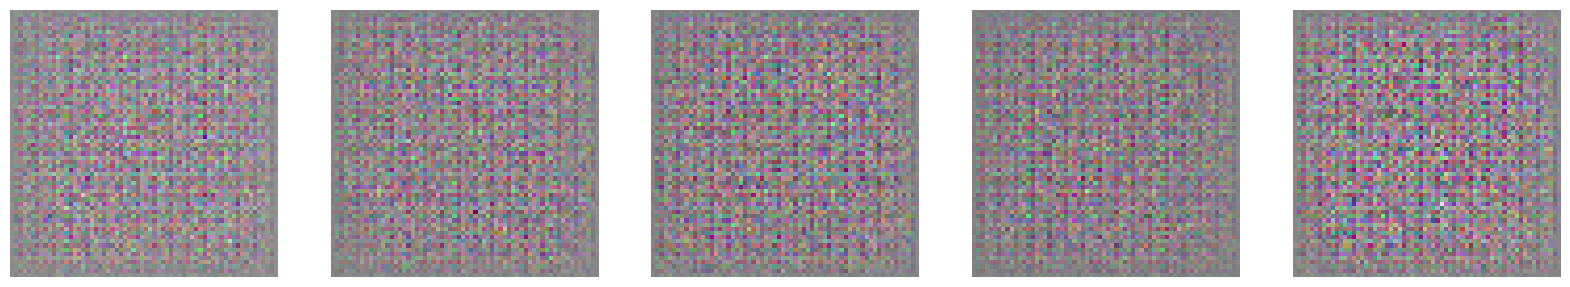

In [21]:
generator= make_generator()
BATCH_SIZE=128

latent_dim=100
noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
Xhat=generator(noise,training=False)
plot_array(Xhat)

## Entrenamiento del Model


Como este método requiere mucha computación, entrenaremos el modelo para una época y luego usaremos el generador para producir imágenes artificiales.

In [24]:
epochs=1

discriminator=make_discriminator()

generator= make_generator()


for epoch in range(epochs):

    #data for the true distribution of your real data samples training ste
    start = time.time()
    i=0
    for X in tqdm(normalized_ds, desc=f"epoch {epoch+1}", total=len(normalized_ds)):

        i+=1
        if i%1000:
            print("epoch {}, iteration {}".format(epoch+1, i))

        train_step(X)


    noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
    Xhat=generator(noise,training=False)
    X=[x for x in normalized_ds]
    print("orignal images")
    plot_array(X[0])
    print("generated images")
    plot_array(Xhat)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 1, iteration 1
epoch 1, iteration 2
epoch 1, iteration 3
epoch 1, iteration 4
epoch 1, iteration 5
epoch 1, iteration 6
epoch 1, iteration 7
epoch 1, iteration 8
epoch 1, iteration 9
epoch 1, iteration 10
epoch 1, iteration 11
epoch 1, iteration 12
epoch 1, iteration 13
epoch 1, iteration 14
epoch 1, iteration 15
epoch 1, iteration 16
epoch 1, iteration 17
epoch 1, iteration 18
epoch 1, iteration 19
epoch 1, iteration 20
epoch 1, iteration 21
epoch 1, iteration 22
epoch 1, iteration 23
epoch 1, iteration 24
epoch 1, iteration 25
epoch 1, iteration 26
epoch 1, iteration 27
epoch 1, iteration 28
epoch 1, iteration 29
epoch 1, iteration 30
epoch 1, iteration 31
epoch 1, iteration 32
epoch 1, iteration 33
epoch 1, iteration 34
epoch 1, iteration 35
epoch 1, iteration 36
epoch 1, iteration 37
epoch 1, iteration 38
epoch 1, iteration 39
epoch 1, iteration 40
epoch 1, iteration 41
epoch 1, iteration 42
epoch 1, iteration 43
epoch 1, iteration 44
epoch 1, iteration 45
epoch 1, iteration 

KeyboardInterrupt: 

Como puede ver, con solo una época de entrenamiento y una cantidad reducida de imágenes de entrenamiento, nuestra GAN no aprendió mucha información y, por lo tanto, el generador no pudo producir imágenes que tengan sentido para los ojos humanos. Hay dos acciones rápidas que puede realizar para intentar mejorar los resultados:

1. Vuelva a entrenar la GAN utilizando el conjunto de datos completo que tiene 63.632 imágenes.
 - Para hacerlo, simplemente regrese a la sección **Cargando el conjunto de datos**, reemplace la URL del conjunto de datos con "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud /IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module5/L2/cartoon_data.tgz", cambie el argumento `directorio` en `tf.keras.utils.image_dataset_from_directory` a ``cartoon_data'` y vuelva a ejecutar todas las celdas.
 - Tenga en cuenta que el uso de más datos de entrenamiento permite que el modelo aprenda mejor y funcione mejor, ¡pero resultará en un tiempo de entrenamiento más largo! **Con 63.000 imágenes de entrenamiento y un tamaño de lote de 128, su modelo se entrenará durante aproximadamente 497 iteraciones.**


2. Utilice un modelo generador previamente entrenado para generar imágenes.
 - ¡No necesitas experimentar el tiempo de entrenamiento en absoluto!
 - Continúe con la siguiente subsección para cargar un modelo previamente entrenado y verá que el generador entrenado con 150 épocas puede producir caras de anime casi realistas.


### Cargando modelo previamente entrenado (150 épocas)

Como vio, entrenar una GAN con una sola época lleva bastante tiempo. Si queremos evaluar el rendimiento de una GAN completamente entrenada y optimizada, necesitaríamos aumentar la cantidad de épocas. Por lo tanto, para ayudarlo a evitar un tiempo de entrenamiento extremadamente largo en esta práctica de laboratorio, simplemente descargaremos los parámetros de red del Generador previamente entrenado y luego usaremos la función `load_model` de Kera para obtener un Generador previamente entrenado, que usaremos para generar imágenes directamente.


In [22]:
generator_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/generator.tar.gz"
await skillsnetwork.prepare(generator_url, overwrite=True)

  0%|          | 0/7 [00:00<?, ?it/s]

Saved to '.'


Cargar el generador:


In [23]:
from tensorflow.keras.models import load_model


full_generator=load_model("generator")

Generemos varias imágenes usando el Generador completamente entrenado y mostrémoslas:


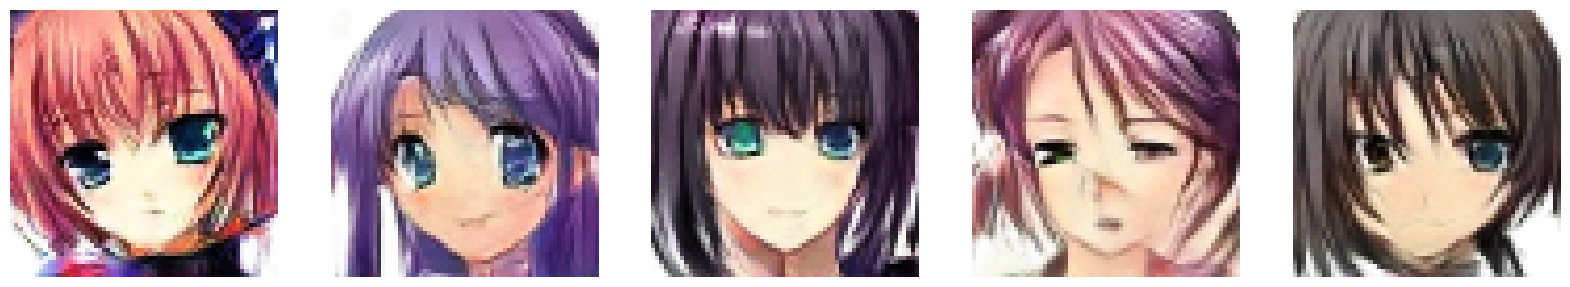

In [24]:
latent_dim=100

# input consists of noise vectors
noise = tf.random.normal([200, 1, 1, latent_dim])

# feed the noise vectors to the generator
Xhat=full_generator(noise,training=False)
plot_array(Xhat)

## Explorando las Variables latentes

Los valores de $\mathbf{z}$ que están relativamente juntos producirán imágenes similares. Por ejemplo, podemos asignar elementos de $\mathbf{z}$ valores cercanos como $[1,0.8,..,0.4]$.


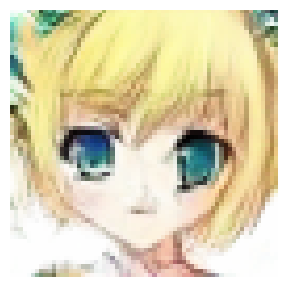

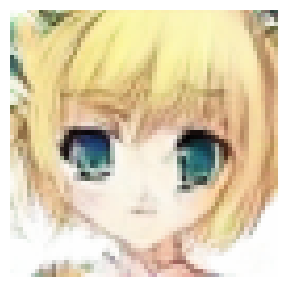

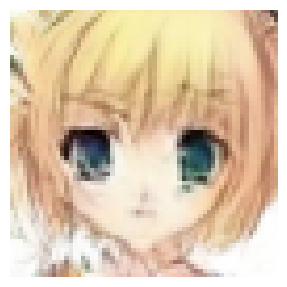

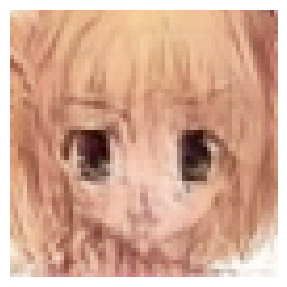

In [25]:
for c in [1,0.8,0.6,0.4]:
    Xhat=full_generator(c*tf.ones([1, 1, 1, latent_dim]),training=False) # latent_dim = 100 defined previously
    plot_array(Xhat)

### Exercise 1

Traza las imágenes generadas por el Generador con elementos de $\mathbf{z}$ iguales a $[-1,-0.8,-0.6,-0.4]$.


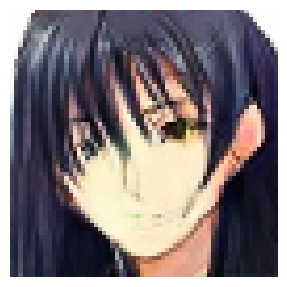

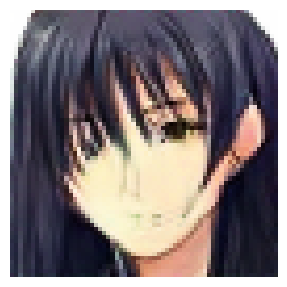

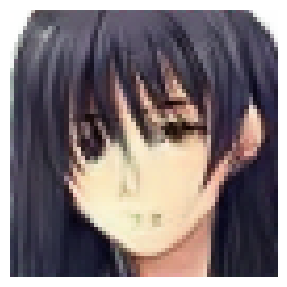

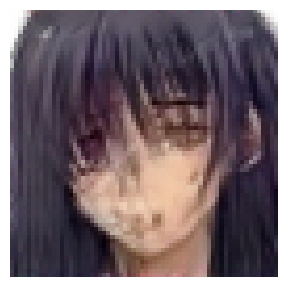

In [26]:
for c in [1,0.8,0.6,0.4]:
    Xhat=full_generator(-c*tf.ones([1, 1, 1, latent_dim]),training=False)
    plot_array(Xhat)

Podemos ver cómo cambiar la variable latente cambia la imagen generada. Aquí modificamos más y más valores posteriores de $\mathbf{z}$ de 1 a -1; vemos que las imágenes cambian en consecuencia; Esto es evidente en el color de cabello del personaje de anime:


elements from 0 to 0 is set to -1


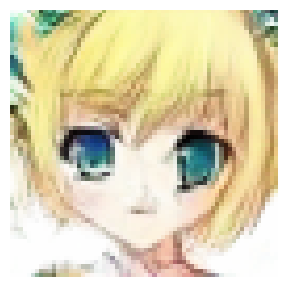

elements from 0 to 10 is set to -1


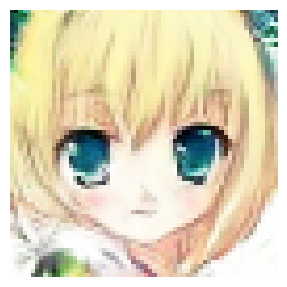

elements from 0 to 20 is set to -1


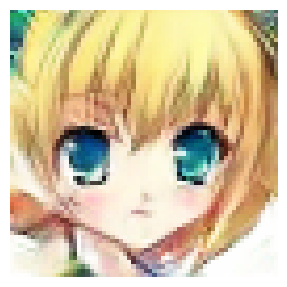

elements from 0 to 30 is set to -1


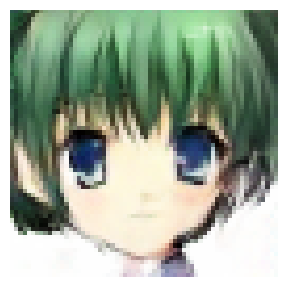

elements from 0 to 40 is set to -1


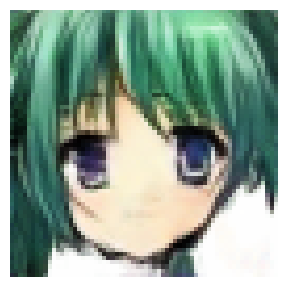

elements from 0 to 50 is set to -1


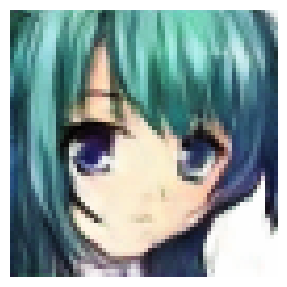

elements from 0 to 60 is set to -1


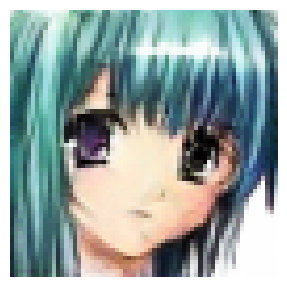

elements from 0 to 70 is set to -1


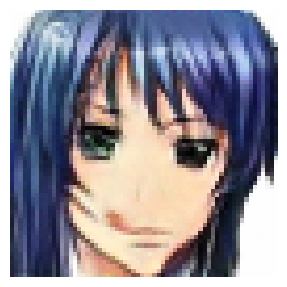

elements from 0 to 80 is set to -1


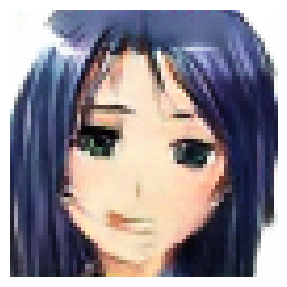

elements from 0 to 90 is set to -1


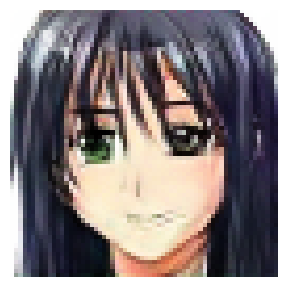

In [27]:
z=np.ones( (1, 1, 1, latent_dim))
for n in range(10):

    z[0, 0, 0, 0:10*n]=-1

    Xhat=full_generator(z,training=False)
    print("elements from 0 to {} is set to -1".format(10*n))
    plot_array(Xhat)

### Exercise 2

Repita el procedimiento anterior pero establezca la variable latente $z[0, 0, 0, 0:20*n] = -0.5*n$ cada vez `para n en el rango(5)`


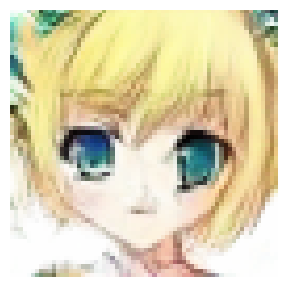

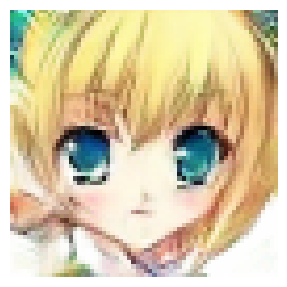

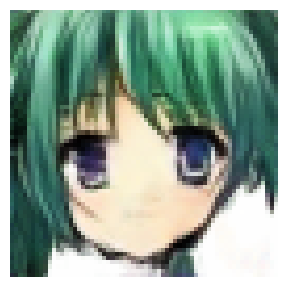

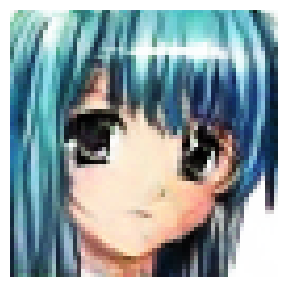

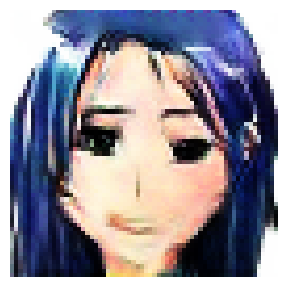

In [28]:
z=np.ones( (1, 1, 1, latent_dim))
for n in range(5):

    z[0, 0, 0, 0:20*n]=-0.5*n

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)

También podemos mantener constantes algunos de los elementos de $\mathbf{z}$ y cambiar otros aleatoriamente. Aquí, configuramos los primeros 20 elementos en uno y cambiamos aleatoriamente el resto. Vemos que a lo largo de las imágenes cambian, el color del cabello permanece claro.


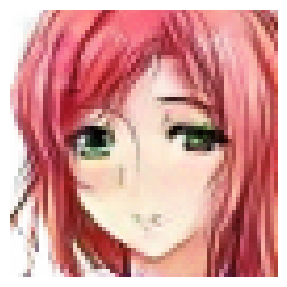

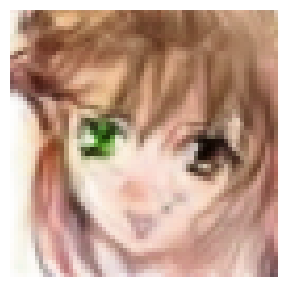

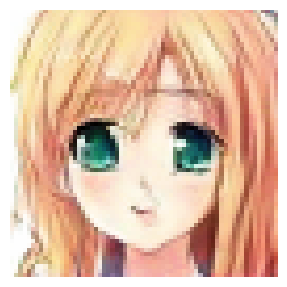

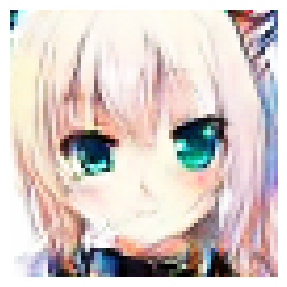

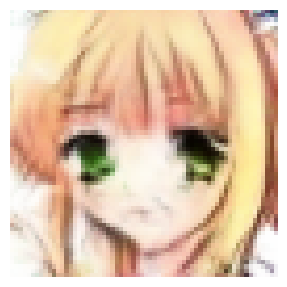

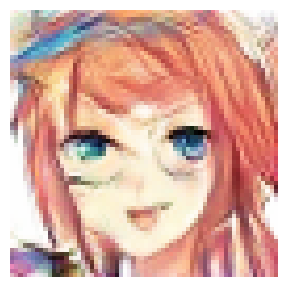

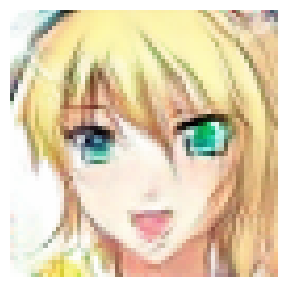

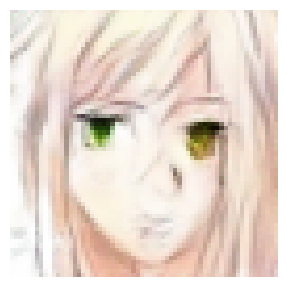

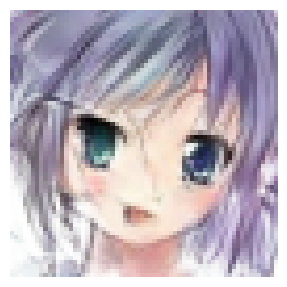

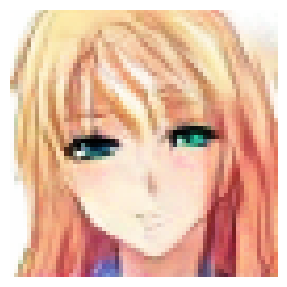

In [29]:
for n in range(10):
    z=np.random.normal(0, 1, (1, 1, 1, latent_dim))

    z[0,0,0,0:35]=1

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)

### Exercise 3

Repita el procedimiento anterior, pero establezca los elementos de $\mathbf{z}$ del índice 0 al 35 en -1


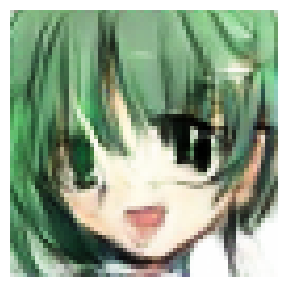

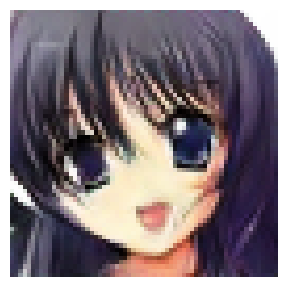

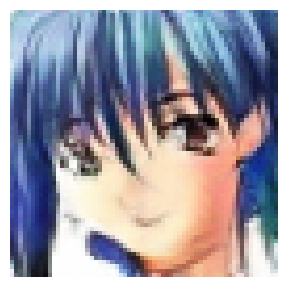

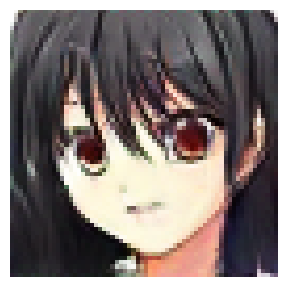

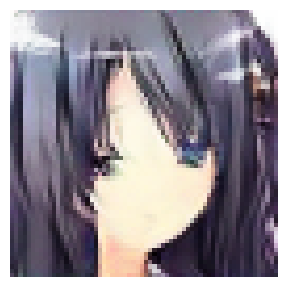

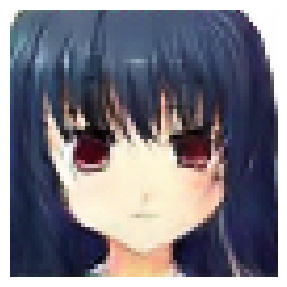

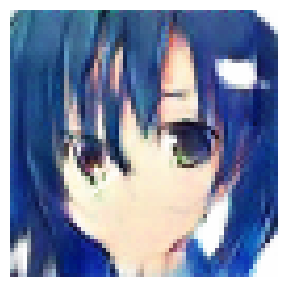

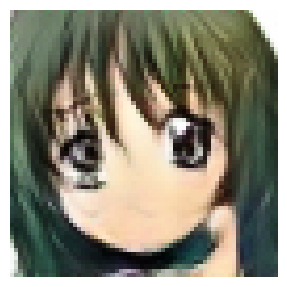

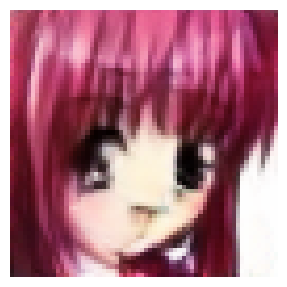

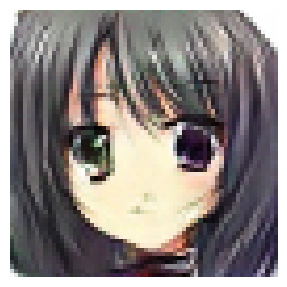

In [30]:
for n in range(10):
    z=np.random.normal(0, 1, (1, 1, 1, latent_dim))

    z[0,0,0,0:35]=-1

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)